<a href="https://colab.research.google.com/github/Amitrk619/Plant-based-disease-detection/blob/main/Plant_Based_Disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# New Section

# Connect with Google Drive 

In below section we connect with google drive and mount it with our colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tensor 2.0 Installation

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0


     |████████████████████████████████| 332.1MB 49kB/s 
     |████████████████████████████████| 419kB 33.8MB/s 
     |████████████████████████████████| 3.0MB 41.4MB/s 


Import Libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals;
import tensorflow as tf
import cv2
import numpy as np;
from matplotlib import pyplot as plt;
import os;
import pathlib;
import random;
import sklearn
from sklearn.metrics import classification_report, confusion_matrix;
print(tf.__version__)

2.2.0


Variable assignment

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE;

model_loc = '/content/gdrive/My Drive/Refined_Data/saved_model';
plant_data = '/content/gdrive/My Drive/Refined_Data/plant_data';

img_width = 160;
img_height = 160;
test_batch_size = 1;
train_batch_size = 64;
valid_batch_size = 32;


Helper functions for building dataset

In [ ]:
def fetch_images_path(data_dir):
  images_path = list(data_dir.glob('*/**/*'));
  images_path = [str(path) for path in images_path];
  random.shuffle(images_path);
  return images_path;

def get_labels(data_dir):
  label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir());
  label_index = dict((name, index) for index,name in enumerate(label_names));
  return label_names, label_index;

def generate_images_labels(images_path, label_index):
  images_labels = [label_index[pathlib.Path(path).parent.name]
                    for path in images_path];
  return images_labels;

def build_dataset(images_path, images_label):
  path_ds = tf.data.Dataset.from_tensor_slices(images_path);
  image_ds = path_ds.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE);
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(images_label, tf.int64));
  image_label_ds = tf.data.Dataset.zip((image_ds, label_ds));
  return image_label_ds;

def load_images(path):
  image = tf.io.read_file(path);
  image = tf.image.decode_jpeg(image, channels=3);
  image = tf.image.resize(image, [160, 160]);
  image /= 255.0;
  return image;

Load Images Path and Get Label Indices

In [ ]:
data_root = pathlib.Path(plant_data)
print(data_root);

images_path = fetch_images_path(data_root);

label_name, label_index = get_labels(data_root);

print(len(images_path));

print(label_name);
print(label_index);

/content/gdrive/My Drive/Refined_Data/plant_data
253
['diseased_data', 'healthy_data']
{'diseased_data': 0, 'healthy_data': 1}


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Splitting Images path in Training, Validation and Test

In [ ]:
total_images = len(images_path);
test_size = tf.cast(tf.math.ceil(total_images * 0.05), tf.int32).numpy();
valid_size = tf.cast(tf.math.ceil(total_images * 0.15), tf.int32).numpy();
train_size = total_images - test_size - valid_size;

print(train_size, valid_size, test_size);

test_images_path = images_path[:test_size];
valid_images_path = images_path[test_size:test_size+valid_size];
train_images_path = images_path[test_size+valid_size:];

print("Test data size : ", len(test_images_path));
print("Train data size : ", len(train_images_path));
print("Train data size : ", len(valid_images_path));

202 38 13
Test data size :  13
Train data size :  202
Train data size :  38


Validating Data Distribution

In [ ]:
def data_dist(images_path):
  hl_count = 0;
  ds_count = 0;
  for y in images_path:
    if pathlib.Path(y).parent.name == 'healthy_data':
      hl_count = hl_count + 1;
    else:
      ds_count = ds_count + 1;
  return hl_count, ds_count;

print("Test Data Dist : ", data_dist(test_images_path))
print("Valid Data Dist : ", data_dist(valid_images_path))
print("Train Data Dist : ", data_dist(train_images_path))

Test Data Dist :  (2, 11)
Valid Data Dist :  (13, 25)
Train Data Dist :  (35, 167)


Building Dataset

In [ ]:

test_labels = generate_images_labels(test_images_path,label_index);
valid_labels = generate_images_labels(valid_images_path,label_index);
train_labels = generate_images_labels(train_images_path,label_index);

test_dataset = build_dataset(test_images_path,test_labels);
valid_dataset = build_dataset(valid_images_path,valid_labels);
train_dataset = build_dataset(train_images_path,train_labels);

print(test_dataset);
print(valid_dataset);
print(train_dataset);

<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


Configure Train, Validation and Test Dataset

In [ ]:

train_ds = train_dataset.cache();
train_ds = train_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_images_path)));
train_ds = train_ds.batch(train_batch_size).prefetch(buffer_size=AUTOTUNE);

train_steps=tf.math.ceil(len(train_images_path)/train_batch_size).numpy()
print(train_steps);

valid_ds = valid_dataset.cache();
valid_ds = valid_ds.batch(valid_batch_size);
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE);

valid_steps=tf.math.ceil(len(valid_images_path)/valid_batch_size).numpy()
print(valid_steps);

test_ds = test_dataset.cache();
test_ds = test_ds.batch(test_batch_size);
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE);

test_steps=tf.math.ceil(len(test_images_path)/test_batch_size).numpy()
print(test_steps);

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
4.0
2.0
13.0


Functions for Plotting

In [ ]:
def plotaccuracy(history):
  train_acc = history['accuracy'];
  val_acc = history['val_accuracy'];

  epochs = range(1,len(train_acc)+1);

  plt.plot(epochs,train_acc,'b', label="Training Accuracy");
  plt.plot(epochs,val_acc,'r', label="Validation Accuracy");
  plt.title("Training Validation Accuracy");
  plt.legend();
  plt.show();
  
def plotloss(history):
  train_loss = history['loss'];
  val_loss = history['val_loss'];

  epochs = range(1,len(train_loss)+1);

  plt.plot(epochs,train_loss,'b', label="Training Loss");
  plt.plot(epochs,val_loss,'r', label="Validation Loss");
  plt.title("Training Validation Loss");
  plt.legend();
  plt.show();
  return;

Model Design and Training

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.5938
Epoch 00001: val_loss improved from inf to 1.13726, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
4/4 [==============================] - 1s 125ms/step - loss: 0.7895 - accuracy: 0.5938 - val_loss: 1.1373 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.8320
Epoch 00002: val_loss improved from 1.13726 to 1.09283, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
4/4 [==============================] - 0s 84ms/step - loss: 0.5433 - accuracy: 0.8320 - val_loss: 1.0928 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.8242
Epoch 00003: val_loss improved from 1.09283 to 0.75914, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final

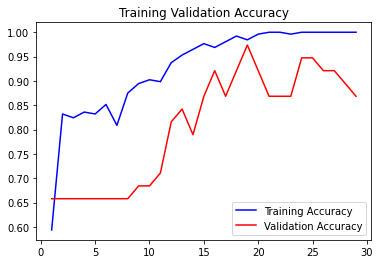

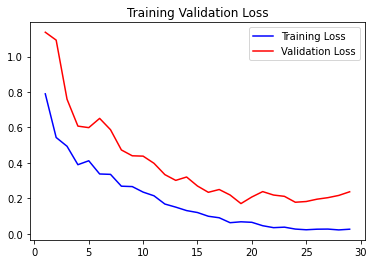

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.8594
Epoch 00001: val_loss did not improve from 0.17029
4/4 [==============================] - 1s 150ms/step - loss: 1.7981 - accuracy: 0.8594 - val_loss: 0.8571 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8125
Epoch 00002: val_loss did not improve from 0.17029
4/4 [==============================] - 0s 112ms/step - loss: 0.4003 - accuracy: 0.8125 - val_loss: 0.4566 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8633
Epoch 00003: val_loss did not improve from 0.17029
4/4 [==============================] - 0s 113ms/step - loss: 0.3025 - accuracy: 0.8633 - val_loss: 0.9713 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8633
Epoch 00004: val_loss did not improve

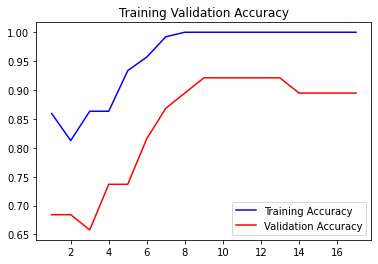

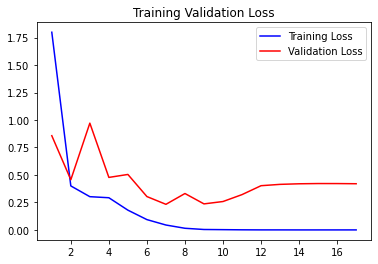

In [ ]:
def train_vgg16_model(train_dataset, valid_dataset, model_path, train_steps, valid_steps):
  conv_base = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(160, 160, 3));
  conv_base.trainable = False;
  model = tf.keras.Sequential()
  model.add(conv_base)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'));

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy']);

  earlystop = tf.keras.callbacks.EarlyStopping(patience=10);
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.000001);
  modelsave = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True, verbose=1)

  model.fit_generator(train_dataset, steps_per_epoch=train_steps, epochs=100, validation_steps=valid_steps,
                          validation_data=valid_dataset,callbacks=[earlystop, modelsave, reduce_lr]);
  
  history = model.history.history;

  plotaccuracy(history);
  plotloss(history);
  
  conv_base.trainable = True;
  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy']);
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001);
  
  model.fit_generator(train_dataset, steps_per_epoch=train_steps, epochs=100, validation_steps=valid_steps,
                          validation_data=valid_dataset,callbacks=[earlystop, modelsave, reduce_lr]);
  
  history = model.history.history;

  plotaccuracy(history);
  plotloss(history);
  return model;

model_name = os.path.join(model_loc,'pc_tf_fine_160_final.h5');
model_vgg16 = train_vgg16_model(train_ds,valid_ds,model_name,train_steps,valid_steps);

Test Data Accuracy and Report

In [ ]:

predictions = model_vgg16.predict_generator(test_ds, steps=test_steps,verbose=1);

predicted_classes = [];
for i in predictions:
  if i >= 0.5:
    predicted_classes.append(1)
  else:
    predicted_classes.append(0);
    

#report = classification_report(test_labels, predicted_classes, target_names=label_name)
#print(report)

print(sklearn.metrics.f1_score(test_labels, predicted_classes,average='micro'))

conf_matrix = confusion_matrix(y_true=test_labels, y_pred=predicted_classes)
print(conf_matrix)

13/13 [==============================] - 0s 5ms/step
0.9230769230769231
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[11  0]
 [ 1  1]]
